In [112]:
from typing import Tuple
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Notebook display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

In [113]:
game_info = pd.read_csv("/kaggle/input/top-1000-steam-games/93182_steam_games.csv").iloc[:, [0, 2, 6]]
print("Dataset shape:", game_info.shape)
game_info.head()

Dataset shape: (93182, 3)


/tmp/ipykernel_37/4185662139.py:1: DtypeWarning:

Columns (3,36) have mixed types. Specify dtype option on import or set low_memory=False.



,AppID,Release date,Price
0,1424640,"Oct 3, 2020",3.99
1,402890,"Sep 23, 2015",0.00
2,1151740,"Apr 2, 2020",19.99
3,875530,"Oct 12, 2018",7.99
4,1835360,"Mar 11, 2022",3.99


In [114]:
player_info = pd.read_csv("/kaggle/input/steam-releases/game_data_all.csv").iloc[:, [2, 4, 8, 9]]
player_info.iloc[:, 0] = player_info.iloc[:, 0].str.replace(r'^/app/(.*)/$', r'\1', regex=True)
player_info.iloc[:, 0] = player_info.iloc[:, 0].astype(int)
print("Dataset shape:", player_info.shape)
player_info.head()

Dataset shape: (67571, 4)


,link,peak_players,rating,primary_genre
0,2231450,4529,96.39,Action (1)
1,2050650,168191,95.75,Action (1)
2,2324650,15543,95.54,Casual (4)
3,2263010,1415,95.39,Indie (23)
4,1817230,6132,95.09,Action (1)


In [122]:
game_info_last_col = game_info.columns[0]
player_info_third_col = player_info.columns[0]

df = game_info.merge(player_info, left_on=game_info_last_col, right_on=player_info_third_col, how='inner')
df = df.iloc[:, [1, 2, 4, 5, 6]]
df['Release date'] = pd.to_datetime(df['Release date'], format='mixed')
df['day'] = df['Release date'].dt.day
df['month'] = df['Release date'].dt.month
df['year'] = df['Release date'].dt.year
df.drop('Release date', axis=1)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (63123, 8)


,Release date,Price,peak_players,rating,primary_genre,day,month,year
0,2020-10-03,3.99,4,45.52,Adventure (25),3,10,2020
1,2015-09-23,0.00,68,61.39,Indie (23),23,9,2015
2,2020-04-02,19.99,165,79.84,Adventure (25),2,4,2020
3,2018-10-12,7.99,3,60.28,Action (1),12,10,2018
4,2022-03-11,3.99,4,60.54,Indie (23),11,3,2022


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



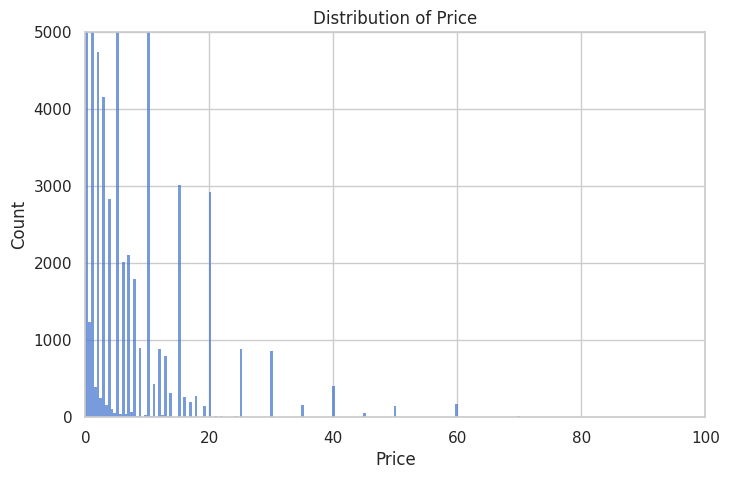

In [142]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'])
plt.title(f"Distribution of Price")
plt.xlim(0, 100)
plt.ylim(0, 5000)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



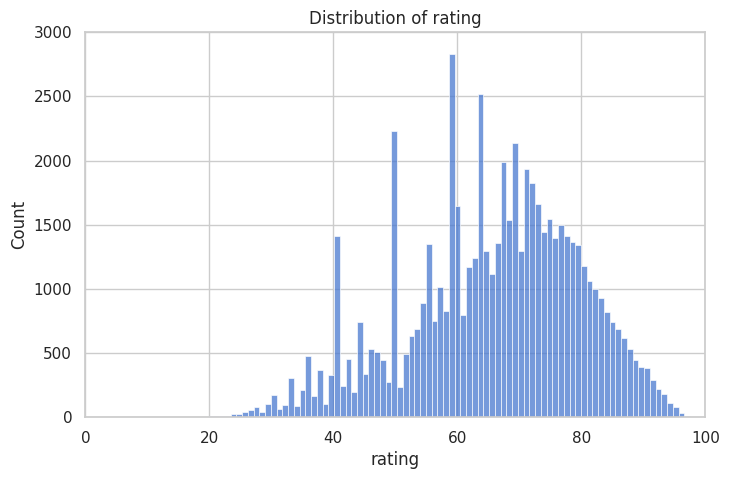

In [143]:
plt.figure(figsize=(8, 5))
sns.histplot(df['rating'])
plt.title(f"Distribution of rating")
plt.xlim(0, 100)
plt.ylim(0, 3000)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



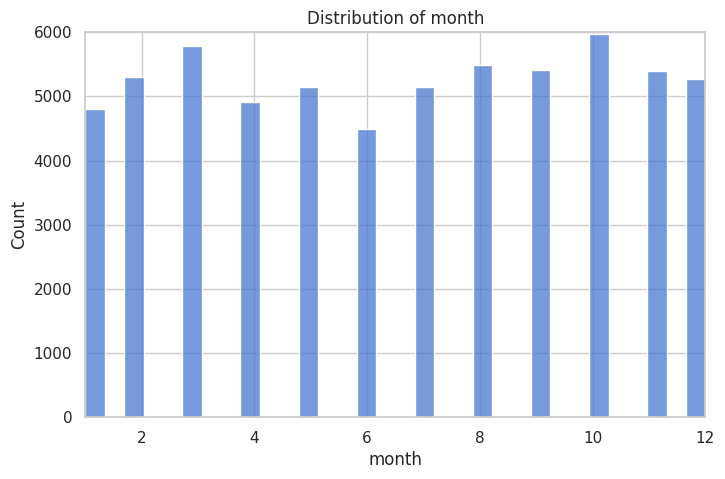

In [145]:
plt.figure(figsize=(8, 5))
sns.histplot(df['month'])
plt.title(f"Distribution of month")
plt.xlim(1, 12)
plt.ylim(0, 6000)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



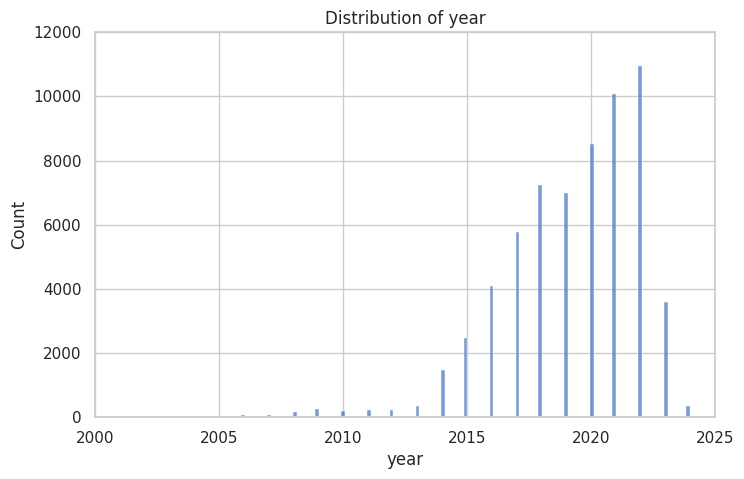

In [150]:
plt.figure(figsize=(8, 5))
sns.histplot(df['year'])
plt.title(f"Distribution of year")
plt.xlim(2000, 2025)
plt.ylim(0, 12000)
plt.show()

In [152]:
from sklearn.preprocessing import OneHotEncoder

X = df[['primary_genre']]

encoder = OneHotEncoder(drop=None, sparse_output=False)
X_encoded = encoder.fit_transform(X)

df_encoded_skl = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(['primary_genre']))
df = pd.concat([df.drop('primary_genre', axis=1), df_encoded_skl], axis=1)
df.head()

KeyError: "None of [Index(['primary_genre'], dtype='object')] are in the [columns]"

,Price,peak_players,rating,day,month,year
count,63123.000000,6.312300e+04,63123.000000,63123.000000,63123.000000,63123.000000
mean,7.324526,9.702194e+02,65.717527,15.946438,6.590545,2019.252174
std,12.270882,2.039624e+04,13.903027,8.844642,3.459890,2.742719
min,0.000000,0.000000e+00,15.090000,1.000000,1.000000,2005.000000
25%,0.990000,3.000000e+00,57.390000,8.000000,3.000000,2018.000000
50%,4.990000,7.000000e+00,67.060000,16.000000,7.000000,2020.000000
75%,9.990000,4.500000e+01,75.850000,23.000000,10.000000,2021.000000
max,999.000000,3.257248e+06,97.540000,31.000000,12.000000,2024.000000


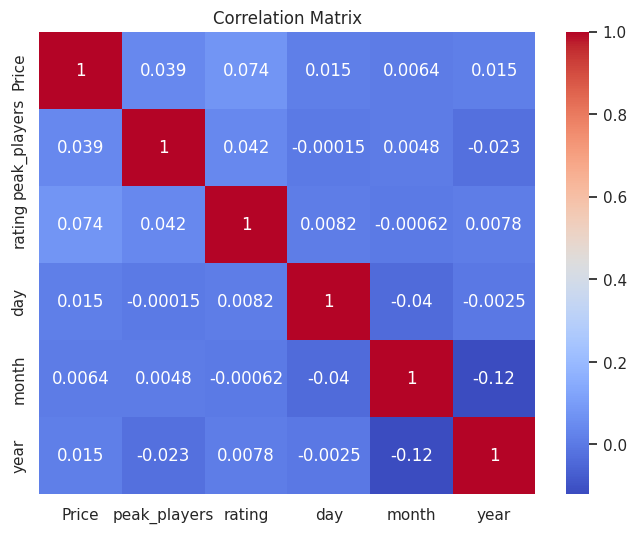

In [153]:
temp_df = df.iloc[:, 1:7]

display(temp_df.describe())

plt.figure(figsize=(8,6))
sns.heatmap(temp_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



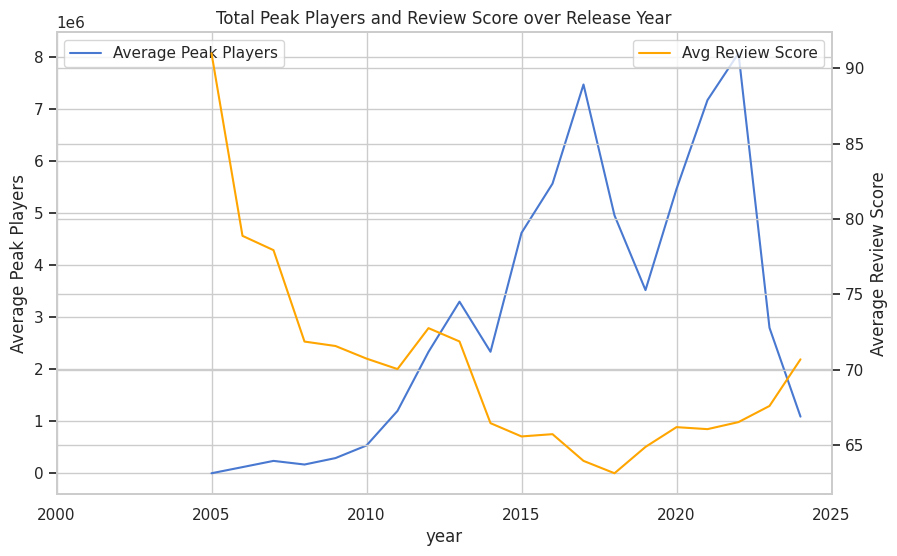

In [160]:
def plot_temporal_trends(df):
    yearly = df.groupby('year').agg({
        'peak_players': 'sum',
        'rating': 'mean'
    }).reset_index()

    fig, ax1 = plt.subplots()
    sns.lineplot(data=yearly, x='year', y='peak_players', label='Average Peak Players', ax=ax1)
    ax1.set_ylabel("Average Peak Players")
    ax2 = ax1.twinx()
    sns.lineplot(data=yearly, x='year', y='rating', color='orange', label='Avg Review Score', ax=ax2)
    ax2.set_ylabel("Average Review Score")
    plt.title("Total Peak Players and Review Score over Release Year")
    plt.xlim(2000, 2025)
    plt.show()

plot_temporal_trends(df)

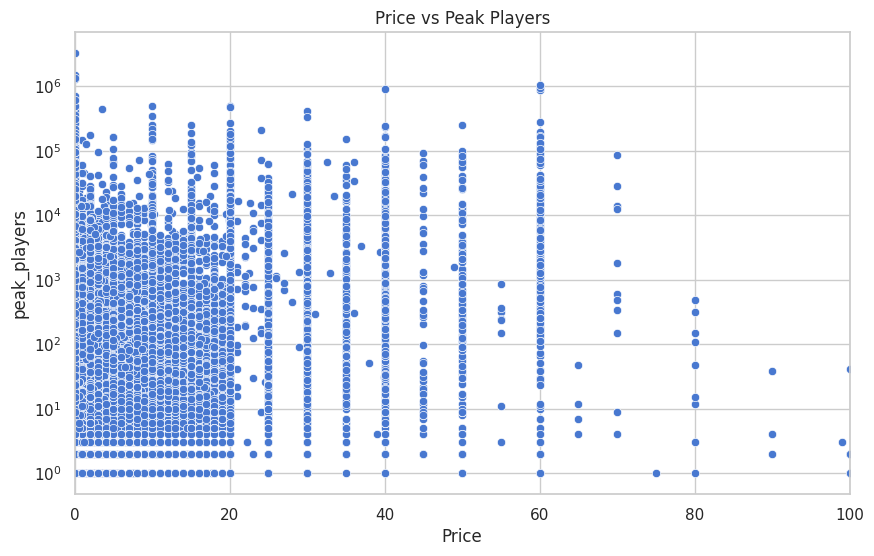

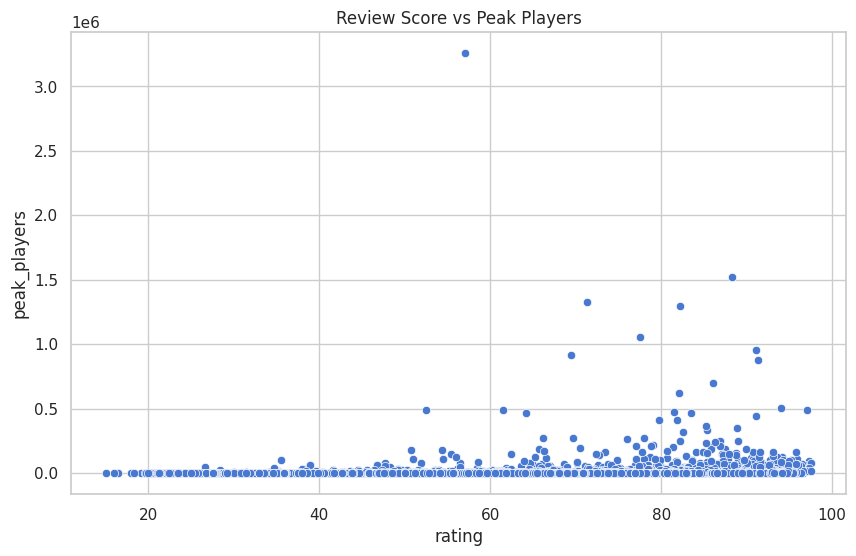

In [168]:
def plot_relationships(df):
    # Price vs Copies Sold
    sns.scatterplot(data=df, x='Price', y='peak_players')
    plt.xlim(0, 100)
    plt.yscale('log')
    plt.title("Price vs Peak Players")
    plt.show()

    # Review Score vs Revenue
    sns.scatterplot(data=df, x='rating', y='peak_players')
    plt.title("Review Score vs Peak Players")
    plt.show()

plot_relationships(df)

In [ ]:
def plot_categorical_insights(df):
    # Average review score by publisher class
    sns.barplot(data=df, x='publisherClass', y='reviewScore', estimator=np.mean, order=df['publisherClass'].value_counts().index)
    plt.title("Average Review Score by Publisher Class")
    plt.xticks(rotation=45)
    plt.show()

    # Top 10 publishers by total revenue
    top_pub = df.groupby('publishers')['revenue'].sum().nlargest(10).reset_index()
    sns.barplot(data=top_pub, x='revenue', y='publishers', palette='viridis')
    plt.title("Top 10 Publishers by Total Revenue")
    plt.show()

plot_categorical_insights(df)

In [ ]:
fig = px.scatter(
    df,
    x='price', y='copiesSold',
    color='publisherClass',
    size='avgPlaytime',
    hover_data=['name', 'publishers', 'reviewScore'],
    title="Interactive Price vs Copies Sold Bubble Plot"
)
fig.show()